## 1. Load libraries and dataset


In [2]:
# Import basic libraries and load the dataset

import pandas as pd                                       # For working with tables and data
import numpy as np                                        # For numerical operations
import matplotlib.pyplot as plt                           # For making charts
import seaborn as sns                                     # For better-looking charts
import re                                                 # For working with text patterns (regular expressions)
import joblib                                             # For saving and loading models
from sklearn.model_selection import train_test_split      # For splitting data into train/test sets

# Plot style
plt.style.use("seaborn-v0_8")
sns.set_palette("Set2")

# Read the data file (make sure the CSV is in the same folder as this notebook)
file_path = "fake_job_postings.csv"
df = pd.read_csv(file_path)

print("Data loaded.")
print("Shape:", df.shape)                 # Shows number of rows and columns

# Show the first few rows so we can understand what the data looks like
df.head()


Data loaded.
Shape: (17880, 18)


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


## 2. Quick data check (info and missing values)

In [3]:
# Check basic information about the dataset
# This shows column names, data types, and how many non-missing values each column has
df.info()

# Check how many missing (empty) values each column has
print("\nMissing values per column:")
print(df.isnull().sum())

# Check how balanced the target variable is
# This tells us how many job posts are real vs fake
print("\nTarget distribution (fraudulent):")
print(df["fraudulent"].value_counts())

# Show the percentage of real vs fake job posts
print("\nTarget percentage distribution (fraudulent):")
print(df["fraudulent"].value_counts(normalize=True) * 100)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [4]:
def missing_values_table(df):
        # Count how many missing values each column has
        mis_val = df.isnull().sum()

        # Calculate what percentage of the column is missing
        mis_val_percent = 100 * df.isnull().sum() / len(df)

        # Combine the counts and percentages into one table
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

        # Rename the columns to make them easier to understand
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})

        # Remove columns with 0 missing values, sort by highest % missing, and round numbers
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)

        # Print a short summary message
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")

        # Return the final missing-values table
        return mis_val_table_ren_columns


# Call the function and save the result
missing_values= missing_values_table(df)

# Display the table with a color gradient (darker red = more missing)
missing_values.style.background_gradient(cmap='Reds')

Your selected dataframe has 18 columns.
There are 12 columns that have missing values.


,Missing Values,% of Total Values
salary_range,15012,84.000000
department,11547,64.600000
required_education,8105,45.300000
benefits,7212,40.300000
required_experience,7050,39.400000
function,6455,36.100000
industry,4903,27.400000
employment_type,3471,19.400000
company_profile,3308,18.500000
requirements,2696,15.100000


## 3. Basic cleaning and create combined text column

In [5]:
# Fill missing values in text and categorical columns

# List of text columns where missing values should be replaced with ""
text_cols = ["title", "company_profile", "description", "requirements", "benefits"]

# List of category columns where missing values should be replaced with "unknown"
cat_cols = ["employment_type", "required_experience", "required_education"]

# Replace missing text with an empty string so the model can process it
for col in text_cols:
    df[col] = df[col].fillna("")

# Replace missing categories with the label 'unknown'
for col in cat_cols:
    df[col] = df[col].fillna("unknown")

print("Missing values handled.")


Missing values handled.


## 4. Text cleaning function and create combined text

In [6]:
# Simple text cleaning function
def clean_text(text):
    text = text.lower()                              # Change all text to lowercase
    text = re.sub(r"http\S+", "", text)              # Remove any website links (URLs)
    text = re.sub(r"\d+", "", text)                  # Remove numbers
    text = re.sub(r"[^\w\s]", "", text)              # Remove punctuation (like ! , ? .)
    text = re.sub(r"\s+", " ", text).strip()         # Remove extra spaces
    return text

# Combine multiple text columns into one column
# This helps the model read all job information as a single block of text
df["combined_text"] = (
    df["title"] + " " +
    df["company_profile"] + " " +
    df["description"] + " " +
    df["requirements"] + " " +
    df["benefits"]
)

# Apply the cleaning function to the combined text
df["combined_text"] = df["combined_text"].apply(clean_text)

print("Text cleaned and combined.")



Text cleaned and combined.


## 5. Train–test split

In [7]:
# Define features and target
# X = the text we will use to train the model
# y = the label (0 = real job post, 1 = fake job post)
X = df["combined_text"]
y = df["fraudulent"].astype(int)   # convert target to integers

# Split the data into training and testing parts
# test_size=0.2 means 20% of the data will be used for testing
# stratify=y keeps the same percentage of fake/real posts in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train/Test Split Done.")
print("Train size:", len(X_train))  # number of samples in training set
print("Test size:", len(X_test))    # number of samples in test set


Train/Test Split Done.
Train size: 14304
Test size: 3576


In [8]:
# Create some simple numeric features from the cleaned text

df["num_chars"] = df["combined_text"].apply(len)
# Counts how many characters are in the text

df["num_words"] = df["combined_text"].apply(lambda x: len(x.split()))
# Counts how many words are in the text

df["num_sentences"] = df["combined_text"].apply(lambda x: x.count('.'))
# Counts how many sentences (by counting periods)

df["count_exclam"] = df["combined_text"].apply(lambda x: x.count('!'))
# Counts how many exclamation marks are in the text

df["count_question"] = df["combined_text"].apply(lambda x: x.count('?'))
# Counts how many question marks are in the text


# Check if the job description contains a URL (from original text, not cleaned)
df["has_url"] = df["description"].apply(
    lambda x: 1 if ("http" in x.lower() or "www" in x.lower()) else 0
)
# If a URL is found, mark as 1; otherwise 0

print("Numeric features created.")


Numeric features created.


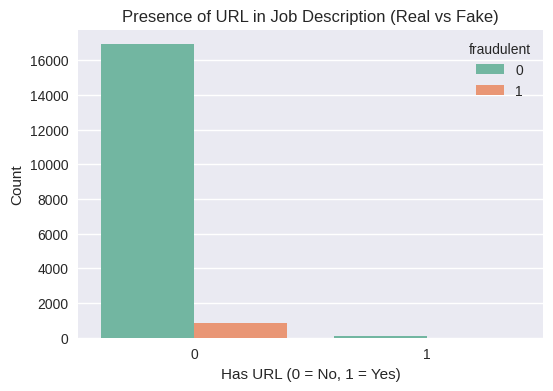

In [9]:
# EDA-3 — Presence of URL vs Fraudulent

# Set the size of the chart
plt.figure(figsize=(6,4))

# Create a bar chart showing how many real vs fake jobs contain a URL
sns.countplot(x="has_url", hue="fraudulent", data=df)

# Add labels and title for better understanding
plt.title("Presence of URL in Job Description (Real vs Fake)")
plt.xlabel("Has URL (0 = No, 1 = Yes)")   # 0 means no URL, 1 means there is a URL
plt.ylabel("Count")

# Show the chart
plt.show()


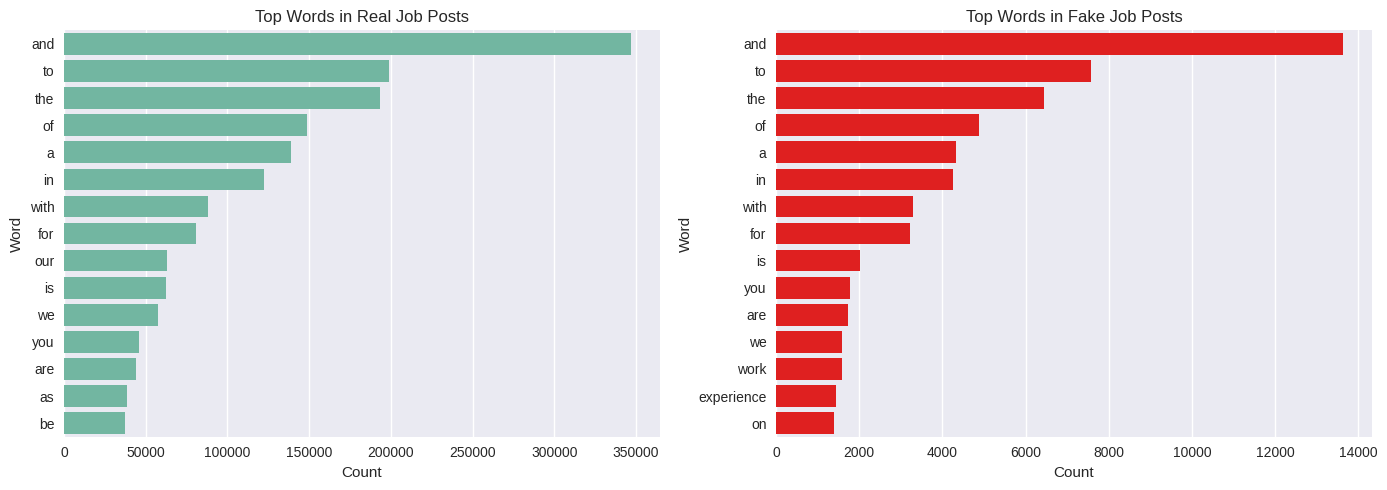

In [10]:
# EDA-4 — Top 15 Most Frequent Words (Real vs Fake)
from collections import Counter

# Function to get the most common words from a list of texts
def get_top_words(texts, n=15):
    words = " ".join(texts).split()     # Join all text together and split into words
    return Counter(words).most_common(n)  # Count words and return top n

# Get top words for real job posts
real_top = get_top_words(df[df["fraudulent"] == 0]["combined_text"])

# Get top words for fake job posts
fake_top = get_top_words(df[df["fraudulent"] == 1]["combined_text"])

# Convert results into DataFrames for easier plotting
real_df = pd.DataFrame(real_top, columns=["word", "count"])
fake_df = pd.DataFrame(fake_top, columns=["word", "count"])

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot top words for real job posts
sns.barplot(y="word", x="count", data=real_df, ax=axes[0])
axes[0].set_title("Top Words in Real Job Posts")
axes[0].set_xlabel("Count")
axes[0].set_ylabel("Word")

# Plot top words for fake job posts
sns.barplot(y="word", x="count", data=fake_df, ax=axes[1], color="red")
axes[1].set_title("Top Words in Fake Job Posts")
axes[1].set_xlabel("Count")
axes[1].set_ylabel("Word")

# Adjust layout so plots fit nicely
plt.tight_layout()
plt.show()


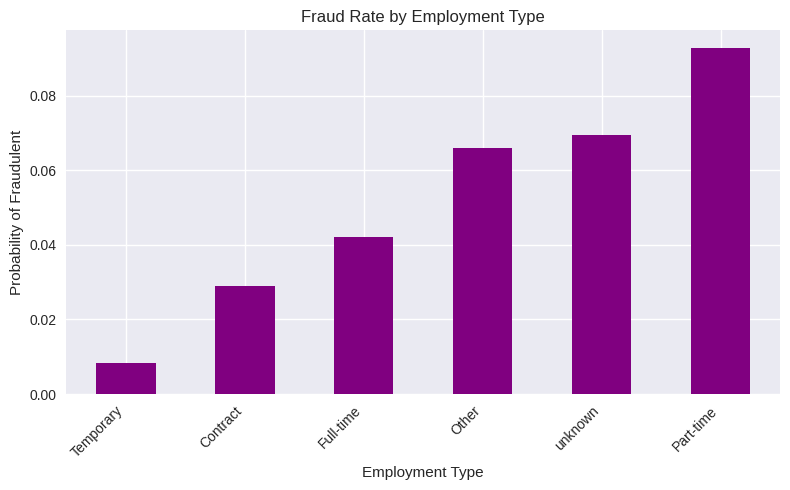

In [11]:
# EDA-5 — Fraud Rate by Employment Type

# Make a figure for the plot
plt.figure(figsize=(8,5))

# Calculate the average fraud rate for each employment type
# (Higher value = more fake job posts in that category)
fraud_rate = df.groupby("employment_type")["fraudulent"].mean().sort_values()

# Create a bar chart to show the fraud rate by employment type
fraud_rate.plot(kind="bar", color="purple")

# Add title and labels to the chart
plt.title("Fraud Rate by Employment Type")
plt.ylabel("Probability of Fraudulent")
plt.xlabel("Employment Type")

# Rotate text on x-axis so it is easier to read
plt.xticks(rotation=45, ha="right")

plt.tight_layout()  # Adjust spacing so nothing overlaps
plt.show()          # Display the chart


## 6. Text vectorization (TF-IDF)
We now convert the cleaned `combined_text` into numerical features using TF-IDF.

In [12]:
# TF-IDF vectorization of the combined text

from sklearn.feature_extraction.text import TfidfVectorizer

# Create a TF-IDF vectorizer
# max_features = keep only the top 5000 most important words
# stop_words = remove common English words (like "the", "and")
# ngram_range = use single words and two-word phrases
tfidf = TfidfVectorizer(
    max_features=5000,
    stop_words="english",
    ngram_range=(1, 2)
)

# Fit the vectorizer on the training text and transform it into numeric vectors
X_train_tfidf = tfidf.fit_transform(X_train)

# Transform the test text using the same rules learned from training data
X_test_tfidf = tfidf.transform(X_test)

# Show the shape of the new TF-IDF matrices
# (rows = number of samples, columns = number of features)
print("TF-IDF shapes:")
print("Train:", X_train_tfidf.shape)
print("Test :", X_test_tfidf.shape)


TF-IDF shapes:
Train: (14304, 5000)
Test : (3576, 5000)


## 7. Train and evaluate models

In this section I train four different models on the TF-IDF features:

- Logistic Regression (balanced)
- Random Forest
- SVM (LinearSVC with calibration)
- XGBoost

I then compare them using accuracy, precision, recall and F1-score for the fake class.

In [13]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(name, y_true, y_pred):
    """Print metrics and show confusion matrix."""

    # Print the model name
    print(f"\n{name}")
    print("-" * len(name))

    # Print accuracy score (how often the model is correct)
    print("Accuracy:", accuracy_score(y_true, y_pred))

    # Print a detailed performance report (precision, recall, F1-score)
    print("\nClassification report:\n")
    print(classification_report(y_true, y_pred))

    # Create the confusion matrix (shows correct and incorrect predictions)
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix as a heatmap
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {name}")
    plt.xlabel("Predicted")   # What the model predicted
    plt.ylabel("Actual")      # The real class labels
    plt.show()


Logistic Regression (balanced)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1271: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn(



Logistic Regression (balanced)
------------------------------
Accuracy: 0.9689597315436241

Classification report:

              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3403
           1       0.62      0.90      0.74       173

    accuracy                           0.97      3576
   macro avg       0.81      0.93      0.86      3576
weighted avg       0.98      0.97      0.97      3576



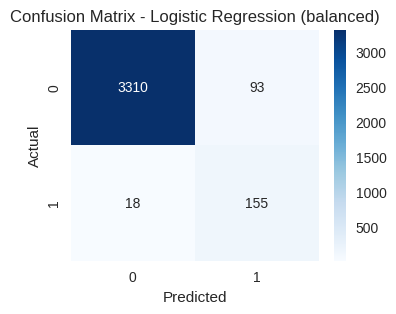

In [14]:
from sklearn.linear_model import LogisticRegression

# Create a Logistic Regression model
# class_weight="balanced" → helps handle the imbalance between real and fake jobs
# max_iter=500 → allows the model more time to train
# n_jobs=-1 → uses all CPU cores for faster training
# solver="liblinear" → works well for smaller datasets and binary classification
log_reg = LogisticRegression(
    class_weight="balanced",
    max_iter=500,
    n_jobs=-1,
    solver="liblinear"
)

# Train (fit) the model using the TF-IDF features
log_reg.fit(X_train_tfidf, y_train)

# Predict the labels (real or fake) for the test set
log_reg_pred = log_reg.predict(X_test_tfidf)

# Use our evaluation function to check accuracy and show confusion matrix
evaluate_model("Logistic Regression (balanced)", y_test, log_reg_pred)


Random Forest


Random Forest
-------------
Accuracy: 0.9773489932885906

Classification report:

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3403
           1       0.94      0.57      0.71       173

    accuracy                           0.98      3576
   macro avg       0.96      0.78      0.85      3576
weighted avg       0.98      0.98      0.97      3576



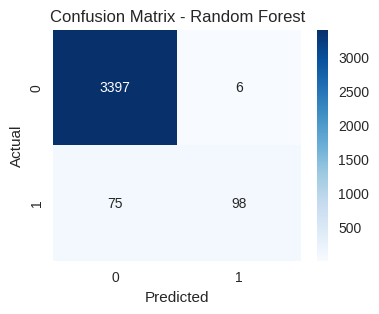

In [15]:
from sklearn.ensemble import RandomForestClassifier

# Create a Random Forest model
# n_estimators = number of trees
# max_depth = None means trees can grow freely
# min_samples_leaf = minimum samples in a leaf node (helps prevent overfitting)
# class_weight = "balanced" helps handle imbalanced classes
# random_state = makes results repeatable
# n_jobs = -1 uses all CPU cores for faster training
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_leaf=2,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

# Train the model on the TF-IDF training data
rf.fit(X_train_tfidf, y_train)

# Predict on the test data
rf_pred = rf.predict(X_test_tfidf)

# Evaluate performance using the function we created earlier
evaluate_model("Random Forest", y_test, rf_pred)


SVM (LinearSVC with calibration)


SVM (LinearSVC, calibrated)
---------------------------
Accuracy: 0.9846196868008948

Classification report:

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      3403
           1       0.93      0.74      0.82       173

    accuracy                           0.98      3576
   macro avg       0.96      0.87      0.91      3576
weighted avg       0.98      0.98      0.98      3576



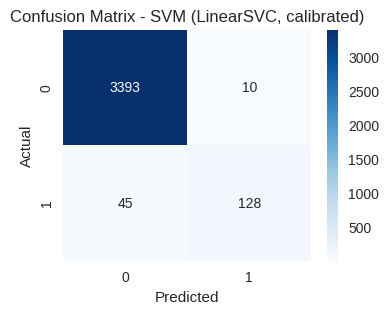

In [16]:
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

# Create the base SVM model
# 'class_weight="balanced"' helps the model treat fake and real jobs more equally
svm = LinearSVC(class_weight="balanced", random_state=42)

# Wrap the SVM in a calibration model
# This allows us to get probability outputs later if we want
svm_calibrated = CalibratedClassifierCV(svm, cv=3)

# Train the calibrated SVM on the TF-IDF training data
svm_calibrated.fit(X_train_tfidf, y_train)

# Make predictions on the test data
svm_pred = svm_calibrated.predict(X_test_tfidf)

# Evaluate the model using accuracy, classification report, and confusion matrix
evaluate_model("SVM (LinearSVC, calibrated)", y_test, svm_pred)


XGBoost (simple, but strong)

scale_pos_weight: 19.640692612351092

XGBoost
-------
Accuracy: 0.9837807606263982

Classification report:

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3403
           1       0.86      0.79      0.83       173

    accuracy                           0.98      3576
   macro avg       0.93      0.89      0.91      3576
weighted avg       0.98      0.98      0.98      3576



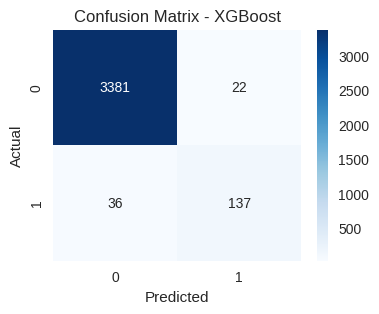

In [17]:
from xgboost import XGBClassifier
import numpy as np

# Count how many real (0) and fake (1) samples are in the training data
neg, pos = np.bincount(y_train)

# This weight helps the model pay more attention to the minority class (fake jobs)
scale_pos_weight = neg / (pos + 1e-6)
print("scale_pos_weight:", scale_pos_weight)

# Build the XGBoost model with tuned settings
xgb_model = XGBClassifier(
    n_estimators=300,        # number of trees
    max_depth=6,            # how deep each tree can go
    learning_rate=0.1,      # how fast the model learns
    subsample=0.8,          # use 80% of rows for each tree
    colsample_bytree=0.8,   # use 80% of columns for each tree
    scale_pos_weight=scale_pos_weight,  # handle class imbalance
    reg_alpha=0.1,          # L1 regularization (helps avoid overfitting)
    reg_lambda=1.0,         # L2 regularization
    eval_metric="logloss",  # evaluation method
    random_state=42,        # for consistent results
    n_jobs=-1               # use all CPU cores
)

# Train the model
xgb_model.fit(X_train_tfidf, y_train)

# Predict on the test set
xgb_pred = xgb_model.predict(X_test_tfidf)

# Evaluate model performance
evaluate_model("XGBoost", y_test, xgb_pred)


Final comparison table (simple)

In [18]:
from sklearn.metrics import precision_score, recall_score, f1_score
import pandas as pd

# Store each model's predictions in a dictionary
# Key = model name, Value = predicted labels
models = {
    "LogReg (balanced)": log_reg_pred,
    "RandomForest": rf_pred,
    "SVM": svm_pred,
    "XGBoost": xgb_pred
}

rows = []  # This will store one row per model for the results table

# Loop through each model and calculate evaluation scores
for name, y_pred in models.items():

    # Accuracy = overall correct predictions
    acc = accuracy_score(y_test, y_pred)

    # Precision_fake = out of all predicted fake jobs, how many were truly fake
    prec_fake = precision_score(y_test, y_pred, pos_label=1)

    # Recall_fake = out of all real fake jobs, how many did the model catch
    rec_fake = recall_score(y_test, y_pred, pos_label=1)

    # F1_fake = balance between precision and recall
    f1_fake = f1_score(y_test, y_pred, pos_label=1)

    # Save results for this model
    rows.append({
        "Model": name,
        "Accuracy": acc,
        "Precision_fake": prec_fake,
        "Recall_fake": rec_fake,
        "F1_fake": f1_fake
    })

# Create a table and sort by F1 score (better for fraud detection)
results_df = pd.DataFrame(rows).sort_values("F1_fake", ascending=False).reset_index(drop=True)

print("Final model comparison (sorted by F1 on fake class):")

# Display the results in a table
display(results_df)


Final model comparison (sorted by F1 on fake class):


,Model,Accuracy,Precision_fake,Recall_fake,F1_fake
0,XGBoost,0.983781,0.861635,0.791908,0.825301
1,SVM,0.984620,0.927536,0.739884,0.823151
2,LogReg (balanced),0.968960,0.625000,0.895954,0.736342
3,RandomForest,0.977349,0.942308,0.566474,0.707581


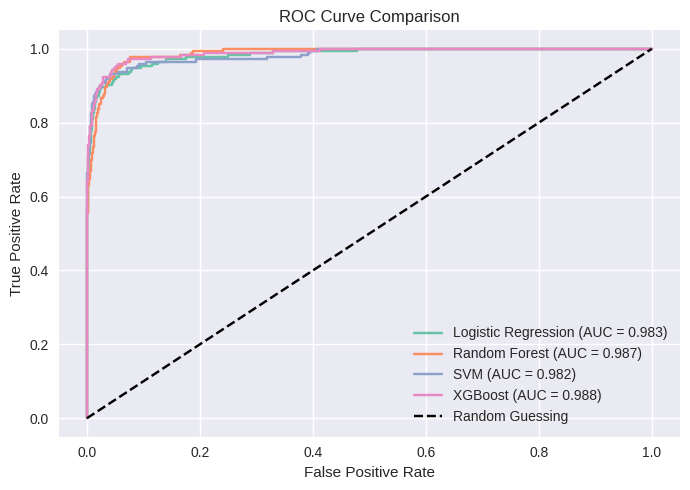

In [19]:
# ROC Curve for all models on one plot (simple version)

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get probability scores from each model
# (These numbers show how likely each job post is fake)
y_score_logreg = log_reg.predict_proba(X_test_tfidf)[:, 1]
y_score_rf     = rf.predict_proba(X_test_tfidf)[:, 1]
y_score_svm    = svm_calibrated.predict_proba(X_test_tfidf)[:, 1]
y_score_xgb    = xgb_model.predict_proba(X_test_tfidf)[:, 1]

# Calculate the values needed for plotting the ROC curve
# fpr = false positive rate, tpr = true positive rate
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_score_logreg)
fpr_rf,     tpr_rf,     _ = roc_curve(y_test, y_score_rf)
fpr_svm,    tpr_svm,    _ = roc_curve(y_test, y_score_svm)
fpr_xgb,    tpr_xgb,    _ = roc_curve(y_test, y_score_xgb)

# Calculate AUC (Area Under Curve) for each model
# Higher AUC = better model
auc_logreg = auc(fpr_logreg, tpr_logreg)
auc_rf     = auc(fpr_rf,     tpr_rf)
auc_svm    = auc(fpr_svm,    tpr_svm)
auc_xgb    = auc(fpr_xgb,    tpr_xgb)

# Plot all ROC curves together so we can compare them
plt.figure(figsize=(7,5))
plt.plot(fpr_logreg, tpr_logreg, label=f"Logistic Regression (AUC = {auc_logreg:.3f})")
plt.plot(fpr_rf,     tpr_rf,     label=f"Random Forest (AUC = {auc_rf:.3f})")
plt.plot(fpr_svm,    tpr_svm,    label=f"SVM (AUC = {auc_svm:.3f})")
plt.plot(fpr_xgb,    tpr_xgb,    label=f"XGBoost (AUC = {auc_xgb:.3f})")

# This is a diagonal line representing random guessing
plt.plot([0, 1], [0, 1], 'k--', label="Random Guessing")

plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()
